# Notebook 02 - Distributions

*Martin Vonk - 2025*

This notebooks shows the process of choosing a distribution and fitting it for your standardized drought index. The notebook is split up in three parts

1. SciPy distributions
2. Comparing data and  distributions
3. Flexible time scales and distribution fitting

Most of the code shown in this notebook is "backend / behind the scenes" code. This is not needed to calculate a drought index, but it can help with the understanding of the user.

## Prerequisites

### Packages

In [1]:
from calendar import month_name
from typing import Literal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
from matplotlib import patheffects
from scipy.stats._survival import EmpiricalDistributionFunction

import spei as si  # si for standardized index

print(si.show_versions())

python: 3.13.1
spei: 0.7.0
numpy: 2.3.1
scipy: 1.16.0
matplotlib: 3.10.3
pandas: 2.3.1


### Helper functions

In [2]:
def plot_ecdf(
    ax: plt.Axes,
    data: pd.Series,
    ecdf: EmpiricalDistributionFunction,
    s: float,
    color: str,
    label: str,
    cdf: pd.Series | None = None,
    **kwargs,
) -> None:
    data = data.drop_duplicates()
    ax.scatter(
        data,
        ecdf.probabilities,
        s=s,
        facecolor=color,
        label=label,
        **kwargs,
    )
    if cdf is not None:
        for idata, icdf, iecdf in zip(data, cdf, ecdf.probabilities):
            ax.plot(
                [idata, idata],
                [iecdf, icdf],
                color=color,
                linewidth=0.5,
                **kwargs,
            )


def axes_indicator(
    ax: plt.Axes,
    letter: str,
    x: float,
    y: float,
    ha: Literal["left", "right"],
    va: Literal["top", "bottom"],
) -> None:
    """Add an indicator to the axes."""
    ax.annotate(
        f"({letter})",
        xy=(x, y),
        xycoords="axes fraction",
        fontsize=mpl.rcParams["axes.titlesize"],
        horizontalalignment=ha,
        verticalalignment=va,
        path_effects=[
            patheffects.Stroke(linewidth=1, foreground="white"),
            patheffects.Normal(),
        ],
    )


def plot_box(ax: plt.Axes, dist: si.dist.Dist, bbox_edgecolor: str = "k") -> None:
    textstr = f"{dist.dist.name}\nparameters\n"
    textstr += f"c = {dist.pars[0]:0.2f}\n"
    textstr += f"loc = {dist.loc:0.1f}\n"
    textstr += f"scale = {dist.scale:0.1f}"
    ax.text(
        xmax - bin * 1.5,
        0.05,
        textstr,
        fontsize=mpl.rcParams["legend.fontsize"] - 0.5,
        horizontalalignment="right",
        verticalalignment="bottom",
        bbox=dict(
            boxstyle="round", facecolor="white", alpha=0.5, edgecolor=bbox_edgecolor
        ),
    )

### Time series data


In [3]:
dfi = pd.read_csv(
    "data/CABAUW.csv",
    index_col=0,
    parse_dates=True,
)
prec = dfi["prec"]
evap = dfi["evap"]
surplus = (prec - evap).rename("surplus")
surplusm = surplus.resample("MS").sum()

## SciPy distributions

In [4]:
scipy_continious_dists = sps._continuous_distns.__all__
print(f"Number of continuous distributions: {len(scipy_continious_dists)}")
print(scipy_continious_dists[0:10])

Number of continuous distributions: 217
['ksone', 'kstwo', 'kstwobign', 'norm', 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford']


As can be seen, SciPy has a lot of different continuous distributions available in its library. Lets explore one.

In [5]:
pearson3 = sps.pearson3
pearson3?

Signature:       pearson3(*args, **kwds)
Type:            pearson3_gen
String form:     <scipy.stats._continuous_distns.pearson3_gen object at 0x7f85ca0de510>
File:            ~/repos/SPEI/.venv/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py
Docstring:      
A pearson type III continuous random variable.

As an instance of the `rv_continuous` class, `pearson3` object inherits from it
a collection of generic methods (see below for the full list),
and completes them with details specific for this particular distribution.

Methods
-------
rvs(skew, loc=0, scale=1, size=1, random_state=None)
    Random variates.
pdf(x, skew, loc=0, scale=1)
    Probability density function.
logpdf(x, skew, loc=0, scale=1)
    Log of the probability density function.
cdf(x, skew, loc=0, scale=1)
    Cumulative distribution function.
logcdf(x, skew, loc=0, scale=1)
    Log of the cumulative distribution function.
sf(x, skew, loc=0, scale=1)
    Survival function  (also defined as ``1 - cdf``,

As can be seen the continuous distribtion has a lot of different methods. Most important for this notebook is the fit method. The fit method, by default, uses a [maximum likelihood estimate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html#scipy.stats.rv_continuous.fit). The method returns the shape parameters (loc, scale and others) of the distribution. Lets see what that looks like for one month of data:

In [6]:
surplus_feb = surplusm[surplusm.index.month == 2].sort_values()

fit_parameters = pearson3.fit(surplus_feb)
fit_cdf = pearson3.cdf(surplus_feb, *fit_parameters)
print(
    "Fit parameters pearson3: loc={:.2f}, scale={:.1f}, skew={:.1f}".format(
        *fit_parameters
    )
)

Fit parameters pearson3: loc=0.24, scale=38.5, skew=26.9


Compare the fitted distribution to the Emperical Cumulative Density Function (similar to the cumulative histogram).

Text(0, 0.5, 'Cumulative probability')

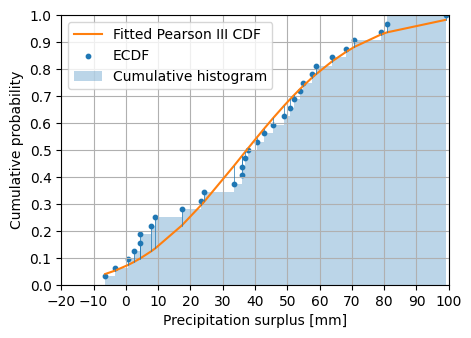

In [7]:
f, ax = plt.subplots(figsize=(5.0, 3.5))

ax.plot(surplus_feb, fit_cdf, color="C1", label=("Fitted Pearson III CDF"))
e_cdf = sps.ecdf(surplus_feb).cdf
plot_ecdf(
    ax=ax, data=surplus_feb, ecdf=e_cdf, s=10, color="C0", label="ECDF", cdf=fit_cdf
)
ax.hist(
    surplus_feb,
    bins=e_cdf.quantiles,
    cumulative=True,
    density=True,
    alpha=0.3,
    color="C0",
    label="Cumulative histogram",
)
ax.legend()
ax.grid(True)
ax.set_xlim(-20.0, 100.0)
ax.set_ylim(0.0, 1.0)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10.0))
ax.set_xlabel("Precipitation surplus [mm]")
ax.set_ylabel("Cumulative probability")

In the SPEI package there is a little wrapper around this dist class that helps with doing some analysis on the distribution. For instance the two-sided Kolmogorov-Smirnov test for goodness of fit. The null hypothesis two-sided test is that the two distributions are identical, the alternative is that they are not identical.

In [8]:
pearson3_pvalue = si.dist.Dist(surplus_feb, pearson3).ks_test()
print(f"Pearson III KS test p-value: {pearson3_pvalue:0.3f}")

Pearson III KS test p-value: 0.747


Say we choose a confidence level of 95%; that is, we will reject the null hypothesis in favor of the alternative if the p-value is less than 0.05. For e.g. march the p-value is lower than our threshold of 0.05, so we reject the null hypothesis in favor of the default “two-sided” alternative: the data are not distributed according to the fitted pearson3 distribution. But not finding the appropriate distribution is one of the big uncertainties of the standardized index method. However, not a perfect fit does not mean this distribution is not fit-for-purpose of calculating a drought index. That is up to the modeller to decide. 

## Comparing data and distributions

We'll reproduce some steps that are normally done internally. Therefor we need to create the SI class and fit the distribution. Well do that for two distributions, the pearson3 and fisk distribution.

In [9]:
spei_pearson3 = si.SI(surplusm, dist=pearson3)
spei_pearson3.fit_distribution()

spei_fisk = si.SI(surplusm, dist=sps.fisk)
spei_fisk.fit_distribution()

Compare for all months:

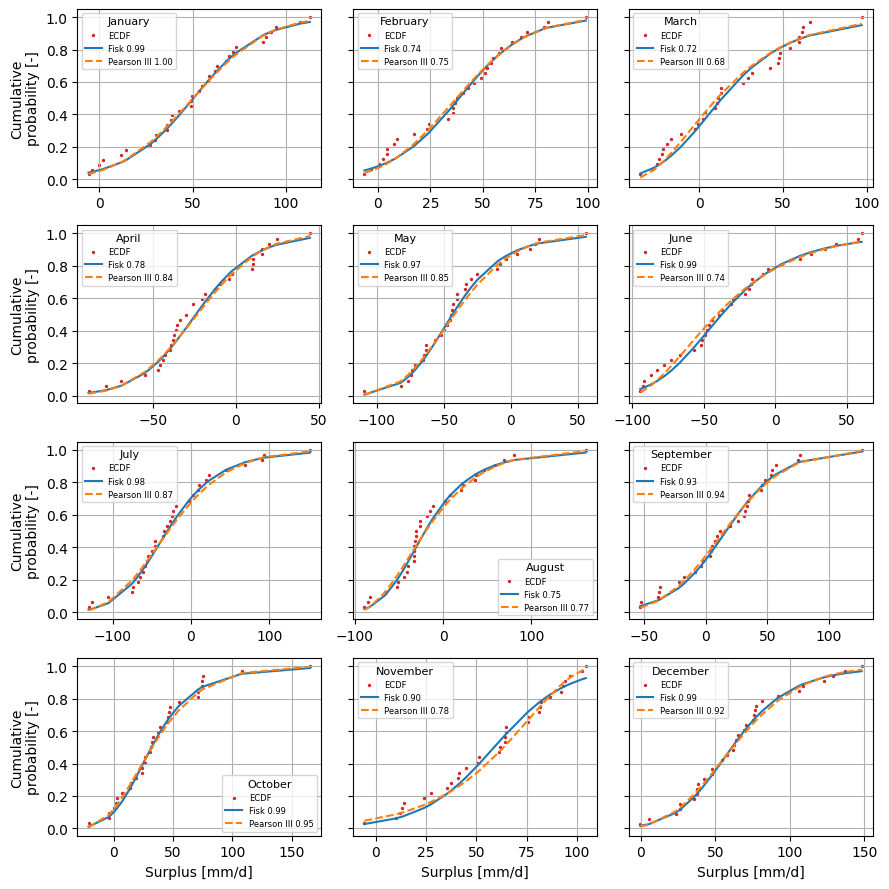

In [10]:
f, axl = plt.subplots(
    4, 3, figsize=(9.0, 9.0), sharey=True, sharex=False, layout="tight"
)
axsr = axl.ravel()
for (date, distf), (_, distp) in zip(
    spei_fisk._dist_dict.items(), spei_pearson3._dist_dict.items()
):
    i = date.month - 1
    cdf_fisk = distf.cdf().sort_values()
    cdf_pearson3 = distp.cdf().sort_values()
    data = distf.data.loc[cdf_fisk.index]
    e_cdf = sps.ecdf(data).cdf
    plot_ecdf(ax=axsr[i], data=data, ecdf=e_cdf, s=2.0, color="C3", label="ECDF")
    axsr[i].plot(
        data.values,
        cdf_fisk.values,
        color="C0",
        linewidth=1.5,
        label=f"Fisk {distf.ks_test():0.2f}",
    )
    axsr[i].plot(
        data.values,
        cdf_pearson3.values,
        color="C1",
        linewidth=1.5,
        label=f"Pearson III {distp.ks_test():0.2f}",
        linestyle="--",
    )
    axsr[i].grid(True)
    axsr[i].legend(fontsize=6, title=month_name[date.month], title_fontsize=8)

_ = [ax.set_ylabel("Cumulative\nprobability [-]") for ax in axl[:, 0]]
_ = [ax.set_xlabel("Surplus [mm/d]") for ax in axl[-1, :]]

Both the Fisk and Pearson3 distirbutions seem to describe the precipitation surplus pretty well. The legend shows the p_value of the two-sided Kolmogorov-Smirnov test for goodness of fit. We can now see more cleary that there is a discrepancy between the data and the fitted distribution. However, the p_value is more than 0.05 for all months and distributions. However the pearson III distirbutions seems to fit a better for larger surplus numbers. Only for November the Fisk distribution looks significantly better/smoother than the pearson3 distribution.

## Flexible time scales and distribution fitting
Meteorological and hydrological time series are nowadays typically available at a daily frequency. To accommodate this, the `timescale` argument in the drought index function is designed to be flexible, with units that match the frequency of the input time series. For example, when using daily data, a `timescale` value of `30` corresponds approximately to a one-month drought index, `90` for three months, `180` for six months, and so on.

The frequency at which distributions are fitted (`fit_freq`) determines how many different distributions are fitted. With a daily fit frequency (`fit_freq="D"`), one distribution is fitted for every day of the year — 365 or 366 in total, depending on leap years. In contrast, a monthly fit (`fit_freq="MS"` or `"ME"`) fits a distribution for every month of the year; 12 in total. Although daily fitting is more computationally intensive, it can yield more precise results, as shown in later sections. Therefore, the number of data points available for each distribution fit depends on both `fit_freq`, the frequency, and the time length of the time series. For instance, with 30 years of monthly data and `fit_freq="MS"`, each monthly distribution is based on 30 data points. However, fitting a distribution to just 30 values can be challenging — especially for daily data, which is more prone to noise and outliers. By default, the package attempts to infer `fit_freq` based on the time series frequency. If inference fails, it defaults to a monthly fit. Users can also specify `fit_freq` manually for full control.

To improve fit stability, the `fit_window` argument allows users to include additional data points around each time step. The window size is specified in the same units as the fit frequency. For example for daily data and fit frequency, `fit_window=3` includes data from the day before and after a given date (e.g., March 14th–16th for March 15th) for the fitting of the distribution. A `fit_window=31` for daily data provides a sample size similar to monthly fitting, while retaining daily resolution. Though experimental, this fit window feature has shown to improve the robustness of daily fits. A fit window with an even number is automaticaly transformed to an odd number.

In [11]:
timescale = 30

spei_d = si.SI(
    series=surplus,
    dist=sps.fisk,
    timescale=timescale,
    fit_freq="D",
    fit_window=0,
)
spei_d.fit_distribution()

fit_window_dw = 31
spei_dw = si.SI(
    series=surplus,
    dist=sps.fisk,
    timescale=timescale,
    fit_freq="D",
    fit_window=fit_window_dw,
)
spei_dw.fit_distribution()

spei_m = si.SI(
    series=surplus,
    dist=sps.fisk,
    timescale=timescale,
    fit_freq="MS",
    fit_window=0,
)
spei_m.fit_distribution()

speid = spei_d.norm_ppf()
speidw = spei_dw.norm_ppf()
speim = spei_m.norm_ppf()

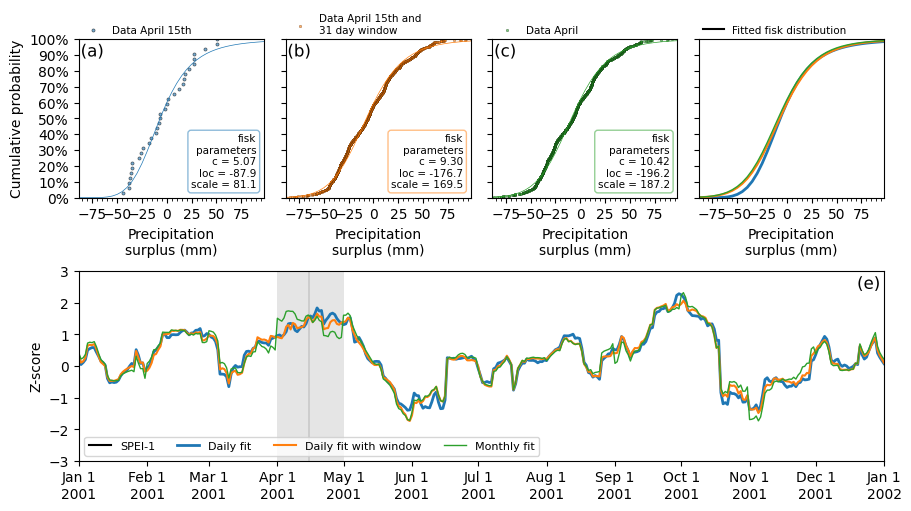

In [12]:
month = 4
ts_d = pd.Timestamp(f"2000-{month}-15")
ts_m = pd.Timestamp(f"2000-{month}-01")
dist_d = spei_d._dist_dict[ts_d]
dist_dw = spei_dw._dist_dict[ts_d]
dist_m = spei_m._dist_dict[ts_m]
data_d = dist_d.data.sort_values()
data_dw = dist_dw.data_window.sort_values()
data_m = dist_m.data.sort_values()
cdf_d = dist_d.cdf().loc[data_d.index]
cdf_dw = dist_dw.dist.cdf(data_dw.values, *dist_dw.pars, dist_dw.loc, dist_dw.scale)
cdf_m = dist_m.cdf().loc[data_m.index]
ecdf_d = sps.ecdf(data_d).cdf
ecdf_dw = sps.ecdf(data_dw).cdf
ecdf_m = sps.ecdf(data_m).cdf

fig, axd = plt.subplot_mosaic(
    [["d", "dw", "m", "cdf"], ["si", "si", "si", "si"]],
    layout="constrained",
    figsize=(9.0, 5.0),
    height_ratios=[1.0, 1.2],
)
scatter_kwargs = dict(
    alpha=0.6,
    zorder=2,
    edgecolors="k",
)
plot_ecdf(
    ax=axd["d"],
    data=data_d,
    ecdf=ecdf_d,
    color="C0",
    label=f"Data {ts_d.strftime('%B %d')}th",
    linewidths=0.5,
    s=5.0,
    **scatter_kwargs,
)
plot_ecdf(
    ax=axd["dw"],
    data=data_dw,
    ecdf=ecdf_dw,
    color="C1",
    label=f"Data {ts_d.strftime('%B %d')}th and\n{fit_window_dw} day window",
    linewidths=0.2,
    s=4.0,
    **scatter_kwargs,
)
plot_ecdf(
    ax=axd["m"],
    data=data_m,
    ecdf=ecdf_m,
    color="C2",
    label=f"Data {ts_m.strftime('%B')}",
    linewidths=0.2,
    s=4.0,
    **scatter_kwargs,
)
bin = 5.0
xmin = min(data_d.min(), data_dw.min(), data_m.min())
xmax = max(data_d.max(), data_dw.max(), data_m.max())
bins = np.arange(xmin // bin * bin, xmax + bin, bin)
axd["d"].set_xlim(xmin, xmax)
axd["d"].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(bin))
axd["d"].xaxis.set_major_locator(mpl.ticker.MultipleLocator(bin * 5))
axd["d"].set_ylim(0.0, 1.0)
axd["d"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
axd["d"].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
for iax in [axd["dw"], axd["m"], axd["cdf"]]:
    iax.sharex(axd["d"])
    iax.sharey(axd["d"])
    for t in iax.get_yticklabels():
        t.set_visible(False)
axd["d"].set_ylabel("Cumulative probability")
axd["d"].set_xlabel("Precipitation\nsurplus (mm)")
axd["dw"].set_xlabel("Precipitation\nsurplus (mm)")
axd["m"].set_xlabel("Precipitation\nsurplus (mm)")
axd["cdf"].set_xlabel("Precipitation\nsurplus (mm)")

axd["d"].plot(
    bins,
    dist_d.dist.cdf(bins, *dist_d.pars, loc=dist_d.loc, scale=dist_d.scale),
    color="C0",
    linewidth=0.5,
)
axd["dw"].plot(
    bins,
    dist_dw.dist.cdf(bins, *dist_dw.pars, loc=dist_dw.loc, scale=dist_dw.scale),
    color="C1",
    linewidth=0.5,
)
axd["m"].plot(
    bins,
    dist_m.dist.cdf(bins, *dist_m.pars, loc=dist_m.loc, scale=dist_m.scale),
    color="C2",
    linewidth=0.5,
)
axd["cdf"].plot(
    [],
    [],
    color="k",
    linewidth=1.5,
    label=f"Fitted {dist_d.dist.name} distribution",
)
axd["cdf"].plot(
    bins,
    dist_d.dist.cdf(bins, *dist_d.pars, loc=dist_d.loc, scale=dist_d.scale),
    color="C0",
    linewidth=2.0,
)
axd["cdf"].plot(
    bins,
    dist_dw.dist.cdf(bins, *dist_dw.pars, loc=dist_dw.loc, scale=dist_dw.scale),
    color="C1",
    linewidth=1.5,
)
axd["cdf"].plot(
    bins,
    dist_m.dist.cdf(bins, *dist_m.pars, loc=dist_m.loc, scale=dist_m.scale),
    color="C2",
    linewidth=1.0,
)

mpl.rcParams["legend.fontsize"] = 8.0

plot_box(axd["d"], dist_d, bbox_edgecolor="C0")
plot_box(axd["dw"], dist_dw, bbox_edgecolor="C1")
plot_box(axd["m"], dist_m, bbox_edgecolor="C2")

axd["d"].legend(
    loc=(0, 1), frameon=False, fontsize=mpl.rcParams["legend.fontsize"] - 0.5
)
axd["dw"].legend(
    loc=(0, 1), frameon=False, fontsize=mpl.rcParams["legend.fontsize"] - 0.5
)
axd["m"].legend(
    loc=(0, 1), frameon=False, fontsize=mpl.rcParams["legend.fontsize"] - 0.5
)
axd["cdf"].legend(
    loc=(0, 1), frameon=False, fontsize=mpl.rcParams["legend.fontsize"] - 0.5
)

axd["si"].plot([], [], color="k", label="SPEI-1")
axd["si"].plot(
    speid.index,
    speid.values,
    linewidth=2.0,
    color="C0",
    label="Daily fit",
)
axd["si"].plot(
    speidw.index,
    speidw.values,
    linewidth=1.5,
    color="C1",
    label="Daily fit with window",
)
axd["si"].plot(
    speim.index,
    speim.values,
    linewidth=1.0,
    color="C2",
    label="Monthly fit",
)

year = 2001
axd["si"].fill_betweenx(
    [-3.0, 3.0],
    ts_m + pd.Timedelta(days=365),
    ts_m + pd.Timedelta(days=365 + 30),
    color="k",
    alpha=0.1,
    linewidth=0,
)
axd["si"].fill_betweenx(
    [-3.0, 3.0],
    ts_d + pd.Timedelta(days=365),
    ts_d + pd.Timedelta(days=365 + 1),
    color="k",
    alpha=0.1,
    linewidth=0,
)
axd["si"].set_xlim(pd.Timestamp(f"{year}"), pd.Timestamp(f"{year + 1}"))
axd["si"].xaxis.set_major_locator(mpl.dates.MonthLocator())
axd["si"].xaxis.set_major_formatter(mpl.dates.DateFormatter("%b%_d\n%Y"))
axd["si"].set_ylabel("Z-score")
axd["si"].grid(False)
axd["si"].legend(ncol=4, loc="lower left")
axd["si"].set_ylim(-3.0, 3.0)
axd["si"].yaxis.set_major_locator(mpl.ticker.MultipleLocator())

axes_indicator(axd["d"], "a", 0.01, 0.98, ha="left", va="top")
axes_indicator(axd["dw"], "b", 0.01, 0.98, ha="left", va="top")
axes_indicator(axd["m"], "c", 0.01, 0.98, ha="left", va="top")
axes_indicator(axd["si"], "e", 0.995, 0.98, ha="right", va="top")

The figure above illustrates the influence of different distribution fitting strategies — namely, `fit_freq` and `fit_window` on the calculation of the SPEI-1 index over the year 2001. The top row displays the cumulative distribution functions of precipitation surplus data for an excerpt of the time series of April (the 15th). Subplot a shows the case where distributions are fitted daily (`fit_freq="D"`) without using a fitting window. Here, the fit is based solely on data from April 15th across 30 years, resulting in a limited sample size and consequently a noisier empirical distribution with a less stable fit. Subplot b also uses a daily fitting frequency but applies a 31-day fitting window (`fit_window=31`) centered on April 15th. This expands the sample to include 31 days of data, significantly increasing the total number of observations and yielding a much smoother and more robust distribution fit. In contrast, Subplot c shows a monthly fitting approach (`fit_freq="MS"`) with no fit window, where all April data from each year is used. This produces a stable fit, but because each month is treated separately, sharp transitions can occur at month boundaries, which may introduce artificial discontinuities into the resulting index. This is shown in the red line of subplot e, which is smoother overall but exhibits abrupt changes at the start of each month (e.g., April 1st and November 1st), due to transitions between monthly distributions. These settings allow users to tailor the standardization process to their data and desired level of temporal precision. Subplot d shows the specific fisk distributions from each parameter set, shown in the text boxes of subplots a,b and c. The changes to the fitted parameter values are obvious, but the fitted distrubtions look similar as seen in subplot d. The result for the z-score is minimal on april 15th but larger for different dates as seen in subplot e.
